# Variant of the Original Jeff Classifier

This notebook copies and build out Part III of `jeff_classifier.py` - that is, the section that trains and tests a classifier on the generated data.

## Setup

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(context='talk')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 343)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution!

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 341)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [7]:
this_metrics = etc_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.8890522875816995


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.600000,0.929825,0.980392,0.500000,0.748366
1,0.363636,0.877193,0.941176,0.333333,0.864379
2,0.444444,0.912281,0.980392,0.333333,0.725490
3,0.428571,0.859649,0.901961,0.500000,0.936275
4,0.400000,0.842105,0.882353,0.500000,0.911765
5,0.500000,0.929825,1.000000,0.333333,0.937908
6,0.727273,0.947368,0.980392,0.666667,0.854575
7,0.666667,0.947368,1.000000,0.500000,0.911765
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


missing_exp_ads_from_simimages_count:max     0.028274
missing_exp_ads_from_simimages_count:50%     0.026173
missing_similar_images_count:50%             0.021064
missing_exp_ads_from_simimages_count:mean    0.020591
missing_similar_images_count:mean            0.019513
missing_similar_images_count:max             0.019349
n_ads                                        0.015921
missing_exp_ads_from_simimages_count:std     0.014729
missing_exp_ads_from_simimages_count:75%     0.013774
flag_Juvenile                                0.013551
missing_similar_images_count:std             0.013501
age:max                                      0.013245
missing_exp_ads_from_simimages_count:25%     0.012073
location_tree_length                         0.012066
missing_age:max                              0.011633
missing_similar_images_count:25%             0.011392
n_distinct_locations                         0.011070
missing_age:std                              0.011012
images_count:mean           

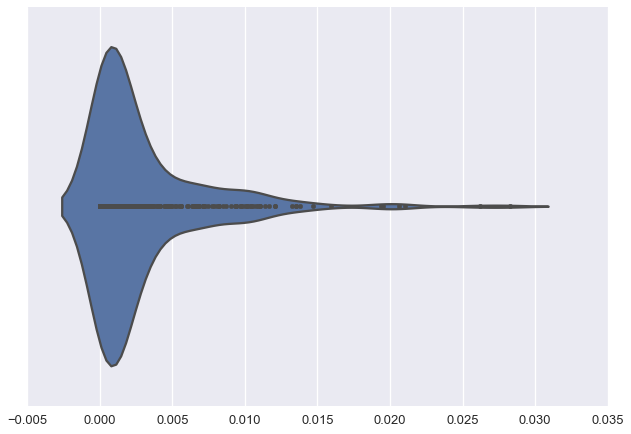

In [8]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

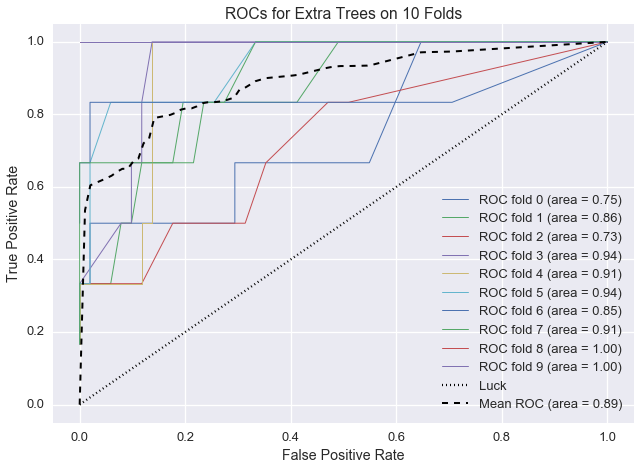

In [9]:
draw_rocs(this_metrics, 'Extra Trees')

### Random Forest

In [10]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))

In [11]:
this_metrics = rf_metrics
print(this_metrics.roc_auc.mean())
this_metrics.loc[:, ['f1', 'accuracy', 'true_negative_rate', 'true_positive_rate', 'roc_auc']]

0.8887254901960786


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc
0,0.600000,0.929825,0.980392,0.500000,0.714052
1,0.363636,0.877193,0.941176,0.333333,0.825163
2,0.444444,0.912281,0.980392,0.333333,0.710784
3,0.400000,0.842105,0.882353,0.500000,0.934641
4,0.400000,0.842105,0.882353,0.500000,0.885621
5,0.500000,0.929825,1.000000,0.333333,0.926471
6,0.727273,0.947368,0.980392,0.666667,0.936275
7,0.666667,0.947368,1.000000,0.500000,0.954248
8,1.000000,1.000000,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000


missing_similar_images_count:mean            0.027843
age:min                                      0.023564
images_count:25%                             0.023122
n_ads                                        0.020879
missing_exp_ads_from_simimages_count:std     0.017814
age:mean                                     0.016967
age:max                                      0.016416
missing_exp_ads_from_simimages_count:mean    0.015556
similar_images_count:50%                     0.015504
missing_similar_images_count:std             0.014167
exp_ads_from_simimages_count:50%             0.013720
flag_Juvenile                                0.013357
images_count:mean                            0.013017
similar_images_count:75%                     0.013016
age:75%                                      0.012924
images_count:max                             0.012322
age:std                                      0.012208
incall_and_outcall:nmlzd_count               0.012153
missing_exp_ads_from_simimag

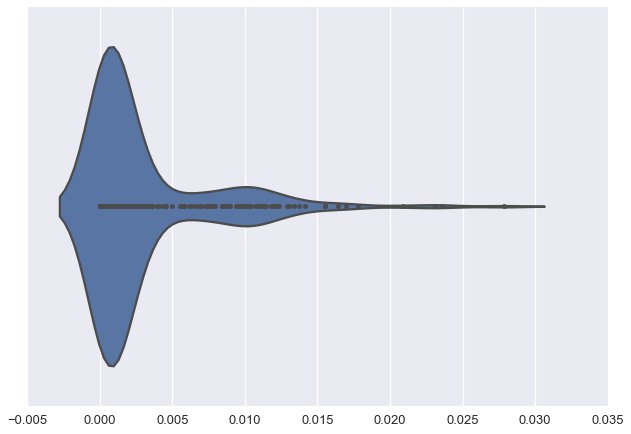

In [12]:
ranked_imptncs = this_metrics.loc[:,
                                  sorted(set(this_metrics.columns) - 
                                         set(eval_columns))].mean().sort_values(ascending=False)
print(ranked_imptncs.head(20))
sns.violinplot(ranked_imptncs, inner='point')

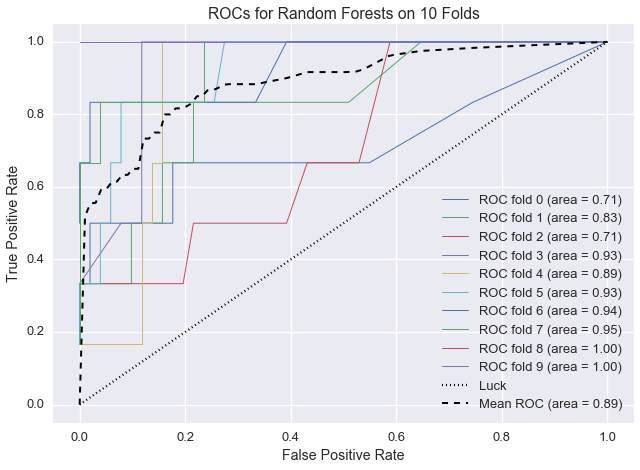

In [13]:
draw_rocs(this_metrics, 'Random Forests')